In [1]:
import os
import pandas as pd
def open_file(fname):

    df = pd.read_excel(fname)

    # Get the filename from the full path
    filename = os.path.basename(fname) 

    if "dv" in filename:
        # Open DV summary spreadsheet
        print("Processing DV file")
        # Keep important and confident genes 
        idx = (df["pval"] < 0.05) & (df["dist_diff"] > 0)
        df = df[idx]
        gene_list = df["gene"]
        print("Number of confident genes : " + str(len(gene_list)))

    else:
        # Open DE summary spreadsheet
        idx = (df['p_val_adj'] < 0.05) &  (df['abs_log2FC'] >= 0.7)
        df = df[idx]
        gene_list = df['gene']
        print("The filename does not contain 'dv'")
    
    return df, gene_list

fname = r"Z:\selim_working_dir\2024_NR4ACKG_Study10_Sc_data\analysis\dv_de_analysis_broad_cells\Colonocytes\ACKG_574_10w_ACKG_577_18w\ACKG_574_10w_ACKG_577_18w_dv.xls"

df, gene_list = open_file(fname)

Processing DV file
Number of confident genes : 300


Number of confident pathways : 1880
Number of confident pathways : 56
Final number of confident pathways : 17
Canvas size 22 17
Final number k (spacing) : 1.41
Final npt_font (pathways) : 15


C:\Users\ssromerogon\AppData\Local\Temp\ipykernel_46808\3419425176.py:38: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_enrichr_df = enrichr_df[enrichr_df['Term'].str.contains('|'.join(keywords), case=False, na=False)]
C:\Users\ssromerogon\AppData\Local\Temp\ipykernel_46808\3419425176.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_enrichr_df['Term'] = filtered_enrichr_df['Term'].apply(clean_pathway_name)
C:\Users\ssromerogon\AppData\Local\Temp\ipykernel_46808\3419425176.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

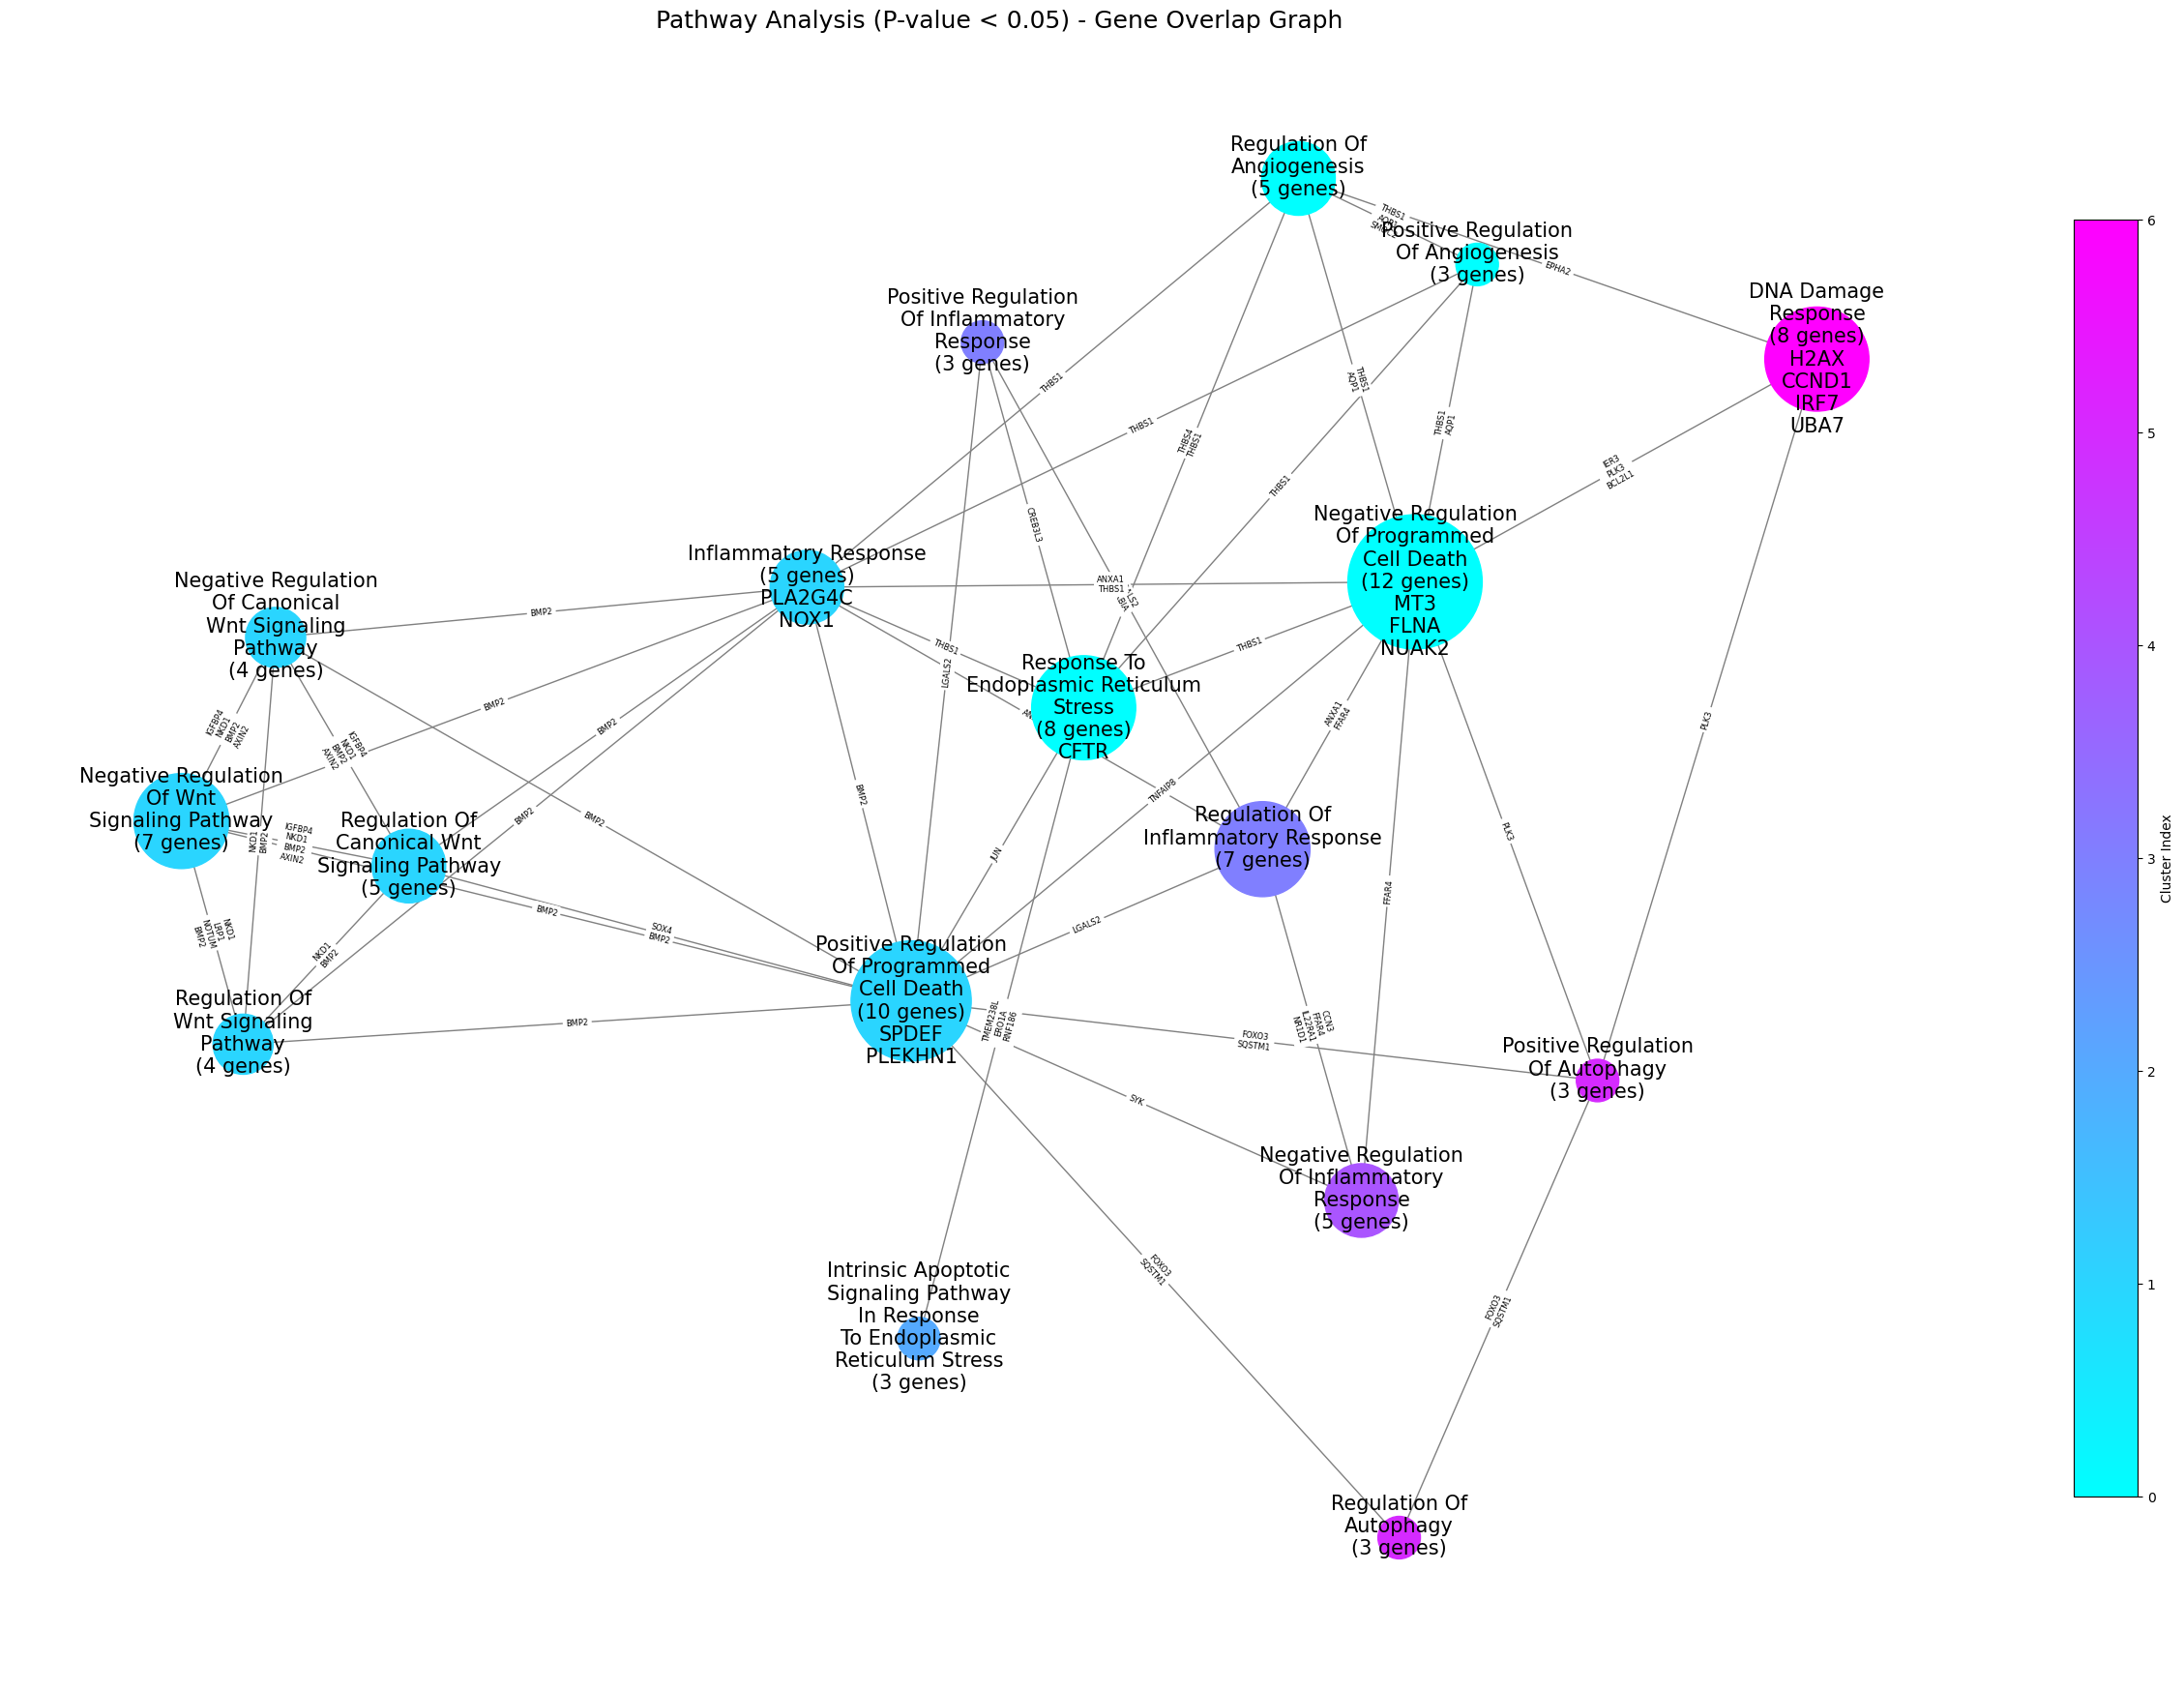

In [2]:
import pandas as pd
import networkx as nx
import igraph as ig
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import re
from math import ceil  # Import ceil from math module
import math
from matplotlib import cm
from matplotlib.colors import Normalize
import gseapy as gp

# Run Enrichr analysis
enrichr_results = gp.enrichr(gene_list=gene_list,
                             gene_sets='GO_Biological_Process_2023',
                             organism='mouse')

# Extract the results DataFrame
enrichr_df = enrichr_results.results

# Filter the DataFrame by the specific gene set 'GO_Biological_Process_2023'
enrichr_df = enrichr_df[enrichr_df['Gene_set'] == 'GO_Biological_Process_2023']


# Print the filtered DataFrame
print("Number of confident pathways : " + str(len(enrichr_df)))

# Define keywords for filtering pathways
keywords = ['apoptosis', 'programmed cell death', 'cell cycle regulation', 
            'tumor necrosis factor (TNF) signaling', 'caspase activation', 
            'DNA damage response', 'autophagy', 'cell survival pathways', 
            'Bcl-2 family proteins', 'NF-kB signaling', 'P53 signaling pathway', 
            'mitochondrial apoptosis signaling', 'inflammatory response', 'Wnt signaling pathway', 
            'MAPK/ERK pathway', 'PI3K-Akt signaling pathway', 'TGF-beta signaling', 'Fas signaling', 
            'endoplasmic reticulum stress', 'angiogenesis', 'epigenetic regulation of apoptosis']

# Step 1: Filter pathways related to programmed cell death and apoptosis
filtered_enrichr_df = enrichr_df[enrichr_df['Term'].str.contains('|'.join(keywords), case=False, na=False)]
# Print the filtered DataFrame
nconfpath = len(filtered_enrichr_df)
print("Number of confident pathways : " + str(nconfpath))

def clean_pathway_name(name):
    # Remove "GO:" followed by numbers and the optional parentheses around GO IDs
    name = re.sub(r'\(GO:\d+\)', '', name)  # Removes "(GO:101010101)" style entries
    return name

# Apply cleaning to the pathway names in the DataFrame
filtered_enrichr_df['Term'] = filtered_enrichr_df['Term'].apply(clean_pathway_name)

# Step 2: Proceed with the graph creation using the filtered DataFrame
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(filtered_enrichr_df['Term'])

# Step 3: Build Graph from Shared Genes
G = nx.Graph()
gene_counts = {}
pathway_gene_map = {}

for _, row in filtered_enrichr_df.iterrows():
    genes = set(row['Genes'].split(';'))  # Convert to set for intersection checks
    pathway_gene_map[row['Term']] = genes
    gene_counts[row['Term']] = len(genes)  # Count genes per term

filtered_enrichr_df['num_genes'] = filtered_enrichr_df['Term'].map(gene_counts)

# Filter pathways that have >= 3 genes
idx = filtered_enrichr_df['num_genes'] >= 3
filtered_enrichr_df = filtered_enrichr_df[idx]

# Recalculate gene counts for the filtered pathways
gene_counts = {term: gene_counts[term] for term in filtered_enrichr_df['Term']}

# Add edges only for shared genes
shared_gene_labels = {}
non_shared_gene_labels = {}
for pathway1, genes1 in pathway_gene_map.items():
    if pathway1 not in filtered_enrichr_df['Term'].values:
        continue
    for pathway2, genes2 in pathway_gene_map.items():
        if pathway1 != pathway2 and pathway2 in filtered_enrichr_df['Term'].values:
            shared_genes = genes1.intersection(genes2)
            if shared_genes:  # Add edge if there are shared genes
                G.add_edge(pathway1, pathway2, weight=len(shared_genes))
                shared_gene_labels[(pathway1, pathway2)] = '\n'.join(shared_genes)  # Insert newline

    # Non-shared genes for the pathway
    non_shared_genes = genes1 - set.union(*[genes2 for pathway2, genes2 in pathway_gene_map.items() if pathway2 != pathway1])
    non_shared_gene_labels[pathway1] = '\n'.join(non_shared_genes)

# Convert NetworkX graph to iGraph
ig_graph = ig.Graph.TupleList(G.edges(data=False), directed=False)

# Run Leiden clustering
partition = ig_graph.community_leiden(resolution_parameter=0.7)  # Experiment with lower values for flexibility

# Assign cluster labels to nodes (pathways)
term_cluster_map = {ig_graph.vs[idx]['name']: cluster for idx, cluster in enumerate(partition.membership)}

# Map clusters to filtered_enrichr_df DataFrame
filtered_enrichr_df['Cluster'] = filtered_enrichr_df['Term'].map(term_cluster_map)

# Dynamically calculate the figure size
nconfpath = len(filtered_enrichr_df)
print("Final number of confident pathways : " + str(nconfpath))

xsize = ceil(nconfpath * 1.25)
ysize = ceil(nconfpath * 1.00)

print("Canvas size " + str(xsize) + " " + str(ysize))
# Step 4: Visualize Graph with Improved Scale
plt.figure(figsize=(xsize, ysize))  # Larger figure size for better visualization

k0 = 0.5
kf = 4.0
kval = round(k0 + kf * (xsize - ysize) / xsize, 2)
print("Final number k (spacing) : " + str(kval))

# Adjust layout spacing with spring_layout
pos = nx.spring_layout(G, seed=42, k=kval, iterations=100)  # Increase 'k' for better spacing

# Map node size to gene count (increase size proportionally)
min_gene_count = min(gene_counts.values())
max_gene_count = max(gene_counts.values())

# Dynamic scaling using min-max normalization with an adjustable range
size_min = 1000  # Minimum node size
size_max = 10000  # Maximum node size

# Apply scaling
node_size = [
    size_min + ((gene_counts[node] - min_gene_count) / (max_gene_count - min_gene_count)) * (size_max - size_min)
    for node in G.nodes()
]

# Map node colors to clusters (color by cluster index using a colormap)
color_map = [plt.cm.cool(cluster / max(term_cluster_map.values())) for cluster in term_cluster_map.values()]

# Function to split text into groups of two words separated by '\n'
def split_pathway_name(name):
    words = name.split()
    return '\n'.join([' '.join(words[i:i+2]) for i in range(0, len(words), 2)])

# Adjust node labels to show each term with breaks every two words and number of genes
labels = {node: f"{split_pathway_name(node)}\n({gene_counts.get(node, 0)} genes)\n{non_shared_gene_labels.get(node, '')}" for node in G.nodes()}

npt_font = ceil(10 * kval)
print("Final npt_font (pathways) : " + str(npt_font))

# Draw the graph
nx.draw(
    G, pos,
    with_labels=True,
    labels=labels,  # Use updated labels with gene count and non-shared genes
    node_color=color_map,  # Color nodes by cluster with distinct colors
    node_size=node_size,
    font_size=npt_font,
    edge_color='gray',
    cmap=plt.cm.Set3
)

# Create a ScalarMappable object for colorbar reference
sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=Normalize(vmin=0, vmax=max(term_cluster_map.values())))
sm.set_array([])  # Empty array for colorbar reference

# Add a thinner colorbar using the 'fraction' and 'pad' arguments
plt.colorbar(sm, ax=plt.gca(), label='Cluster Index', fraction=0.03, pad=0.04)

# Display shared gene labels on edges with a small font size
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=shared_gene_labels,
    font_size=6  # Adjust this to make the font smaller for shared genes
)

plt.title('Pathway Analysis (P-value < 0.05) - Gene Overlap Graph', fontsize=18)
plt.show()
